In [298]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
from mendeleev import element
import nltools
import math
from skimage import draw
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cv2 as cv
from pyefd import elliptic_fourier_descriptors
from scipy.spatial.transform import Rotation as R
from numpy import linalg as LA
import networkx as nx
import random
from collections import namedtuple

In [299]:
coords=[]
elements=[]
for lineidx,line in enumerate(open("data/coordinates_TS/ir_tbp_1_dft-asme3_1_dft-asme3_1_dft-co_1_dft-icn_1_smi1_1_s_1_ts.xyz","r")):
    if lineidx >= 2:
        elements.append(line.split()[0].capitalize())
        coords.append([float(line.split()[1]),float(line.split()[2]),float(line.split()[3])])
coords=np.array(coords)

In [300]:
print(coords)
print(elements)

[[-0.092476 -0.27605  -0.232554]
 [-0.120361 -0.578618 -1.929409]
 [-0.057964  0.36163  -1.983606]
 [ 2.3435   -0.25933  -0.092274]
 [ 3.034775  0.340348  1.63516 ]
 [ 3.244248  0.965707 -1.322539]
 [ 3.262767 -1.963248 -0.375416]
 [ 2.767462  1.407538  1.760456]
 [ 4.135848  0.22427   1.667487]
 [ 2.561803 -0.25739   2.436279]
 [ 2.960168  1.99865  -1.041589]
 [ 2.910162  0.756869 -2.35616 ]
 [ 4.342649  0.846848 -1.244835]
 [ 2.867622 -2.698561  0.351482]
 [ 4.356232 -1.847813 -0.243339]
 [ 3.040024 -2.322309 -1.398132]
 [-2.487998  0.111539 -0.034788]
 [-3.735596 -1.37684  -0.270334]
 [-3.14416   1.488792 -1.252094]
 [-2.946812  0.829995  1.719353]
 [-3.633274 -1.770611 -1.299428]
 [-4.778765 -1.049998 -0.093112]
 [-3.463763 -2.177471  0.444117]
 [-3.051848  1.12571  -2.29326 ]
 [-2.483672  2.365645 -1.110832]
 [-4.196922  1.750306 -1.029876]
 [-2.745766  0.055402  2.483184]
 [-4.007467  1.145726  1.759618]
 [-2.270506  1.689793  1.886898]
 [-0.179204 -1.872994  0.697773]
 [-0.22640

## Center coordinates

Center all coordinates around the metal atom.
Its assumed that the metal center is always the first atom of the file.

In [301]:
#Center
metal = coords[0]
coords = coords - metal

print(coords)

[[ 0.        0.        0.      ]
 [-0.027885 -0.302568 -1.696855]
 [ 0.034512  0.63768  -1.751052]
 [ 2.435976  0.01672   0.14028 ]
 [ 3.127251  0.616398  1.867714]
 [ 3.336724  1.241757 -1.089985]
 [ 3.355243 -1.687198 -0.142862]
 [ 2.859938  1.683588  1.99301 ]
 [ 4.228324  0.50032   1.900041]
 [ 2.654279  0.01866   2.668833]
 [ 3.052644  2.2747   -0.809035]
 [ 3.002638  1.032919 -2.123606]
 [ 4.435125  1.122898 -1.012281]
 [ 2.960098 -2.422511  0.584036]
 [ 4.448708 -1.571763 -0.010785]
 [ 3.1325   -2.046259 -1.165578]
 [-2.395522  0.387589  0.197766]
 [-3.64312  -1.10079  -0.03778 ]
 [-3.051684  1.764842 -1.01954 ]
 [-2.854336  1.106045  1.951907]
 [-3.540798 -1.494561 -1.066874]
 [-4.686289 -0.773948  0.139442]
 [-3.371287 -1.901421  0.676671]
 [-2.959372  1.40176  -2.060706]
 [-2.391196  2.641695 -0.878278]
 [-4.104446  2.026356 -0.797322]
 [-2.65329   0.331452  2.715738]
 [-3.914991  1.421776  1.992172]
 [-2.17803   1.965843  2.119452]
 [-0.086728 -1.596944  0.930327]
 [-0.13393

## Rotate coordinates

Rotate the coordinates around center point. The entire molecule is rotated so that the first to Hydrogen atoms(reaction pocket) are facing up(positive z-axis).

The rotation i9s performed using 3D Rotational matricies.

In [302]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def cosAngle(v1, v2):
  return dotproduct(v1, v2) / (length(v1) * length(v2))

def sinAngle(v1, v2):
  return dotproduct(v1, v2) / (length(v1) * length(v2))

In [303]:
#Rotate
def getRotationMatrix(mean):
    angleY =  -1 * (angle([0,0,1], [mean[0],0,mean[2]]))
    cosAngleY = -1 * (cosAngle([0,0,1], [mean[0],0,mean[2]]))
    #Rotation matric around y-axis
    rotY = np.matrix([[cosAngleY, 0, np.sin(angleY)], [0,1,0], [-np.sin(angleY), 0, cosAngleY]])

    angleX = -1 * (angle([1,0,0], [mean[0], mean[1], 0]))
    cosAngleX = -1 * (cosAngle([1,0,0], [mean[0], mean[1], 0]))
    #Rotation matrix around x-axis
    rotX = np.matrix([[1,0,0], [0,cosAngleX,-np.sin(angleX)], [0, np.sin(angleX),cosAngleX]])

    rot = np.matmul(rotX, rotY)
    return rot
    
mean = (coords[1] + coords[2]) / 2
rotation = getRotationMatrix(mean)

coords_aligned = []
for coord in coords:
    coords_aligned.append(np.asarray(np.dot(rotation, coord)).reshape(-1))

coords = np.array(coords_aligned)
print(coords)

[[ 0.          0.          0.        ]
 [-0.02462354 -1.6905915   0.33605941]
 [ 0.03787751 -1.76324812 -0.6029356 ]
 [ 2.43570188  0.14460285 -0.01958286]
 [ 3.12365542  1.86116777 -0.653324  ]
 [ 3.33881282 -1.10790942 -1.22009034]
 [ 3.35551139 -0.10302756  1.68956529]
 [ 2.85610209  1.9648253  -1.72277253]
 [ 4.22466425  1.89789933 -0.53794969]
 [ 2.64914451  2.67303805 -0.07152425]
 [ 3.05419335 -0.84798371 -2.25837546]
 [ 3.00671409 -2.1378394  -0.99084416]
 [ 4.43706244 -1.02575997 -1.10283265]
 [ 2.95897     0.637506    2.41037765]
 [ 4.44872051  0.0288423   1.57149993]
 [ 3.13473449 -1.11887058  2.06878528]
 [-2.39589769  0.18546035 -0.39133235]
 [-3.64304066 -0.02300898  1.10146024]
 [-3.04971877 -1.06009688 -1.74422313]
 [-2.85808236  1.9241685  -1.1443126 ]
 [-3.53874089 -1.0439178   1.51549718]
 [-4.68654836  0.14571125  0.77121781]
 [-3.37258136  0.70765318  1.88779858]
 [-2.95540579 -2.09370132 -1.36063012]
 [-2.3895035  -0.93493032 -2.6237228 ]
 [-4.10290594 -0.84511633

## Visualize

Visualize the centered and rotated molecule in a 3D grid

In [304]:
def drawSphere(xCenter, yCenter, zCenter, r):
       #draw sphere
       u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
       x=np.cos(u)*np.sin(v)
       y=np.sin(u)*np.sin(v)
       z=np.cos(v)
       # shift and scale sphere
       x = r*x + xCenter
       y = r*y + yCenter
       z = r*z + zCenter
       return (x,y,z)

Element: Ir, r: 2.33
Element: H, r: 1.54
Element: H, r: 1.54
Element: As, r: 2.31
Element: C, r: 1.9
Element: C, r: 1.9
Element: C, r: 1.9
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: As, r: 2.31
Element: C, r: 1.9
Element: C, r: 1.9
Element: C, r: 1.9
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: H, r: 1.54
Element: C, r: 1.9
Element: O, r: 1.71
Element: N, r: 1.79
Element: C, r: 1.9
Element: O, r: 1.71


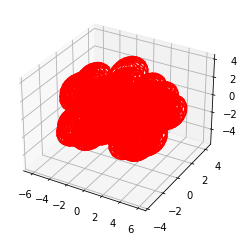

In [305]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
axes = plt.gca()
#axes.set_xlim([-2,2])
#axes.set_ylim([-2,2])
#axes.set_zlim([-2,2])

radii = []
for ((x,y,z), elem) in zip(coords, elements):
    #print((x,y,z))
    r = element(elem).atomic_radius_rahm / 100 #Convert to Angström
    radii.append(r)
    print("Element: " + elem + ", r: " + str(r))
    (xs,ys,zs) = drawSphere(x,y,z,r)
    ax.plot_wireframe(xs,ys,zs, color="r")
    
plt.show()

In [306]:
radii = np.array(radii)
coords = np.array(coords)

print(coords.shape)
print(radii.shape)
print(radii)

(34, 3)
(34,)
[2.33 1.54 1.54 2.31 1.9  1.9  1.9  1.54 1.54 1.54 1.54 1.54 1.54 1.54
 1.54 1.54 2.31 1.9  1.9  1.9  1.54 1.54 1.54 1.54 1.54 1.54 1.54 1.54
 1.54 1.9  1.71 1.79 1.9  1.71]


## Compute Slices

Compute slices of the molecule at given heights.
Each slice is computed by calculating the radius of each atom at the given height. If the radius at the current height is greater than 0 the atom is rendereed in the current slice.

In [307]:
def radiusAtHeight(radius, height):
    relativeHeight = (height - (radius)) / radius
    if relativeHeight <= -1 or relativeHeight >= 1:
        return 0
    return math.sin(math.acos(relativeHeight)) * radius

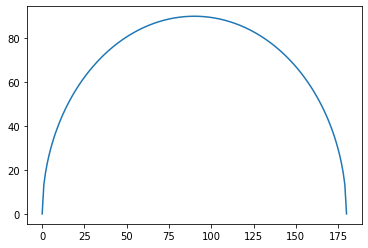

In [308]:
#print(np.amax(arr))
values = []
for x in range(0,181):
    values.append(radiusAtHeight(90, x))
    
plt.plot(values)
plt.show()

In [309]:
coords2d = [[x,y] for (x,y,z) in coords]

voxel_size = 0.05
num_slices, resolution = 100, 100

voxel_space = np.zeros((num_slices, resolution, resolution))

In [310]:
def f(k):
    fig, ax = plt.subplots()
    axes = plt.gca()
    axes.set_xlim([-6.4,6.4])
    axes.set_ylim([-4.8,6.4])
    ax.set_aspect('equal')
    for ((x,y,z), radius) in zip(coords, radii):
        delta_z = ((k * voxel_size) - z)
        slice_radius = radiusAtHeight(radius, delta_z)
        if slice_radius != 0:
            atom = plt.Circle((x,y), slice_radius, color='b')
            ax.add_artist(atom)
    plt.show()

interact(f, k=widgets.FloatSlider(min=-num_slices, max=num_slices, step=1, value=0))

interactive(children=(FloatSlider(value=0.0, description='k', min=-100.0, step=1.0), Output()), _dom_classes=(…

<function __main__.f(k)>

## Compute contour



In [311]:
Circle = namedtuple('Circle', ['x','y','radius'])

In [312]:
def distance(x1,y1,x2,y2):
    return LA.norm(np.array([x1,y1]) - np.array([x2,y2]))

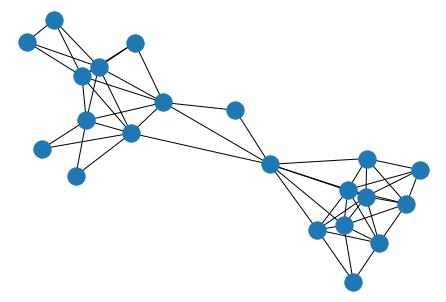

In [313]:
G = nx.Graph()

#Height
k = 0

# Array of (index,(x,y,radius at current height))
# Index is the index of the atom in the current_atom array. Will be used to identify the atom in the graph
current_atoms = []

for ((x,y,z), radius) in zip(coords, radii):
    delta_z = ((k * voxel_size) - z)
    slice_radius = radiusAtHeight(radius, delta_z)
    if slice_radius != 0:
        current_atoms.append(Circle(x,y,slice_radius))
             
for (index,(x,y,radius)) in zip(range(len(current_atoms)), current_atoms):
    G.add_node(index)
        
#Construct graph. Edge if two atoms radii intersect
for (index,(x,y,radius)) in zip(range(len(current_atoms)), current_atoms):
    for (indexe,(xe, ye, radiuse)) in zip(range(len(current_atoms)), current_atoms):
        dist = distance(x,y,xe,ye)
        if dist < (radius + radiuse):
            G.add_edge(index, indexe, intersect=[])
            
nx.draw(G)

In [314]:
def circle_intersection(circle1, circle2):
    (x0, y0, r0) = circle1
    (x1, y1, r1) = circle2
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return []
    # One circle within other
    if d < abs(r0-r1):
        return []
    # coincident circles
    if d == 0 and r0 == r1:
        return []
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return ([x3, y3], [x4, y4])

In [315]:
# Extract the larges connected component
# TODO: The geograpically alrgest CC might not be the CC with the most nodes. Rework in future
largest_cc = max(nx.connected_components(G), key=len)
print(largest_cc)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


In [316]:
for node in largest_cc:
    for neighbor in G.neighbors(node):
        G.edges[node, neighbor]['intersect'] = circle_intersection(current_atoms[node], current_atoms[neighbor])

In [317]:
def angle_to_vec(angle):
    return [np.cos(angle),np.sin(angle)]

In [318]:
# Start at the point furthest to the right. This point is certainly in the contour
biggest_x = []
for node in largest_cc:
    biggest_x.append(current_atoms[node].x + current_atoms[node].radius)

In [319]:
ContourSection = namedtuple('ContourSection', ['index', 'start_angle', 'end_angle'])

In [320]:
# Determine index of the first angle greater than the current angle
def cyclic_min_larger_than(array, lower_bound):
    normalised_array = (np.array(array) - lower_bound) % (2 * np.pi)
    valid_idx = np.where(normalised_array > 0)[0]
    return valid_idx[normalised_array[valid_idx].argmin()]


In [321]:
# Angle beweeen 2 vecs from 0 to 2 PI
def angleFull(v1, v2):
    (x1, y1) = v1
    (x2, y2) = v2
    dot = x1*x2 + y1*y2      # dot product
    det = x1*y2 - y1*x2      # determinant
    angle = np.arctan2(det, dot) 
    return angle % (2*np.pi)

In [322]:
sections = []

active_node = np.argmax(biggest_x)
current_angle = 0

# Add a virtual node to the graph to detect when the contour tracer has reached the beginning again
G.add_node(max(largest_cc) + 1)
G.add_edge(active_node, max(largest_cc) + 1, intersect=[[np.max(biggest_x), current_atoms[active_node].y]])

while True:
    
    
    #print(active_node)
    
    angles = []
    data_for_angle = []
    for neighbor in G.neighbors(active_node):
        for point in G.edges[active_node, neighbor]['intersect']:
            angles.append(angleFull([1,0], [point[0] - current_atoms[active_node].x, point[1] - current_atoms[active_node].y]))
            data_for_angle.append((neighbor, point))

    next_node = data_for_angle[cyclic_min_larger_than(angles, current_angle)][0]
    intersection_point = data_for_angle[cyclic_min_larger_than(angles, current_angle)][1]
    
    #print(np.degrees(angles))
    #print(np.degrees(current_angle))
    contour_section = ContourSection(active_node, current_angle, angles[cyclic_min_larger_than(angles, current_angle)])
    
    sections.append(contour_section)

    if next_node == (max(largest_cc) + 1):
        break
    
    # Compute angle between intersection point and next atom
    current_angle = angleFull([1,0], [intersection_point[0] - current_atoms[next_node].x, intersection_point[1] - current_atoms[next_node].y])
    active_node = next_node
    #print(np.degrees(current_angle))

In [323]:
def points_in_section(circle, section):
    (index, start_angle, end_angle) = section
    (x,y,radius) = circle

    if end_angle < start_angle:
        end_angle += 2*np.pi

    angles = np.arange(start_angle, end_angle, 0.01)
    
    coords_circle = []
    for angle in angles:
        coords_circle.append(((np.cos(angle)*radius) + x, (np.sin(angle) * radius) + y))
        
    return coords_circle

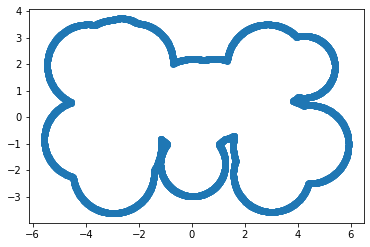

In [324]:
contour_points = []
for section in sections:
    circle = current_atoms[section.index]
    contour_points.extend(points_in_section(circle, section))

#print(contour_points)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(*zip(*list(contour_points)))
ax.set_aspect('equal')
plt.show()

In [325]:
def q(x):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(*zip(*list(contour_points[:x])))
    ax.set_aspect('equal')
    plt.show()

interact(q, x=widgets.IntSlider(min=1, max=len(contour_points), step=20, value=1));

interactive(children=(IntSlider(value=1, description='x', max=3180, min=1, step=20), Output()), _dom_classes=(…

In [295]:
print(elliptic_fourier_descriptors(np.squeeze(contour_points), order=10, normalize=True))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  6.22938850e-01]
 [-3.33659532e-02  1.83316952e-01 -1.59522957e-01 -3.38832692e-02]
 [ 5.97856690e-02 -3.47203265e-02  1.27721662e-02  1.86208085e-01]
 [-4.13646667e-04 -1.36424357e-02 -5.23710623e-02 -1.67864985e-02]
 [ 1.88203792e-02 -3.88889048e-02  4.23592968e-02  1.30893829e-02]
 [ 1.68632548e-02 -9.55205382e-02  1.27302807e-01 -4.90794791e-03]
 [ 1.77970725e-03  2.97808900e-05 -1.92714702e-02 -4.13042247e-02]
 [ 2.38199045e-02 -1.67783857e-02 -4.05605008e-02  2.15539615e-02]
 [ 4.21164043e-02  3.84285720e-03  7.37798974e-03  2.25116409e-02]
 [ 1.23314496e-03  3.60304828e-03  1.03702304e-02  4.49016312e-03]]
